<a href="https://colab.research.google.com/github/Fedor102/Comment_Classification_for_Places_Descriptions/blob/main/Comment_Classification_for_Places_Descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка необходимых пакетов и импорт библиотек

In [ ]:
!pip install emoji==1.4.1
!pip install imblearn

Импортируем библиотеки:

In [ ]:
# Библиотека линейной алгебры
import numpy as np

# Работа с датафреймом
import pandas as pd


# Обработка данных
import re, string
import emoji
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


# Результаты BERT и roBert мы сравним с наивным байесовским классификатором
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Токены и модели из библиотеки transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow import keras

# Метрики
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Для воспроизводимости результатов
seed=42

# Настройка стилей для графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

# Вспомогательные функции

Определим функцию для вывода матрицы ошибок.

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels = ['1', '2', '3', '4', '5']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

### Загрузка данных

#Клонирование репозитория GitHub в Colab

In [ ]:
!git clone https://github.com/yandex/geo-reviews-dataset-2023.git

Cloning into 'geo-reviews-dataset-2023'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 167.74 KiB | 867.00 KiB/s, done.


#Перейдите в папку с датасетом

In [ ]:
%cd geo-reviews-dataset-2023

/content/geo-reviews-dataset-2023/geo-reviews-dataset-2023


#Ознакомьтесь с содержимым

In [ ]:
!ls

AUTHORS.md  CONTRIBUTING.md  geo-reviews-dataset-2023.tskv  LICENSE.md	media  README.md


In [ ]:
# Загрузка файла
import pandas as pd
data = pd.read_csv("geo-reviews-dataset-2023.tskv", sep='\t')
data.head()

,"address=Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников",name_ru=Московский квартал,rating=3.,rubrics=Жилой комплекс,"text=Московский квартал 2.\nШумно : летом по ночам дикие гонки. Грязно : кругом стройки, невозможно открыть окна (16 этаж! ), вечно по району летает мусор. Детские площадки убогие, на большой площади однотипные конструкции. Очень дорогая коммуналка. Часто срабатывает пожарная сигнализация. Жильцы уже не реагируют. В это время, обычно около часа, не работают лифты. Из плюсов - отличная планировка квартир ( Московская 194 ), на мой взгляд. Ремонт от застройщика на 3-. Окна вообще жуть - вместо вентиляции. По соотношению цена/качество - 3."
0,"address=Московская область, Электросталь, прос...",name_ru=Продукты Ермолино,rating=5.,rubrics=Магазин продуктов;Продукты глубокой за...,"text=Замечательная сеть магазинов в общем, хор..."
1,"address=Краснодар, Прикубанский внутригородско...",name_ru=LimeFit,rating=1.,rubrics=Фитнес-клуб,"text=Не знаю смутят ли кого-то данные правила,..."
2,"address=Санкт-Петербург, проспект Энгельса, 11...",name_ru=Snow-Express,rating=4.,rubrics=Пункт проката;Прокат велосипедов;Сапсё...,text=Хорошие условия аренды. \nДружелюбный пер...
3,"address=Тверь, Волоколамский проспект, 39",name_ru=Студия Beauty Brow,rating=5.,"rubrics=Салон красоты;Визажисты, стилисты;Сало...",text=Топ мастер Ангелина топ во всех смыслах )...
4,"address=Иркутская область, Черемхово, Первомай...",name_ru=Tele2,rating=5.,rubrics=Оператор сотовой связи;Интернет-провайдер,"text=Приятное общение, все доступно объяснили,..."


In [ ]:
# Присвоим новые названия колонкам
data.columns = ['address', 'name_ru', 'rating', 'rubrics', 'text']

In [ ]:
# Удаляем префиксы из значений в каждом столбце
data['address'] = data['address'].str.replace(r'^address=', '', regex=True)
data['name_ru'] = data['name_ru'].str.replace(r'^name_ru=', '', regex=True)
data['rating'] = data['rating'].str.replace(r'^rating=', '', regex=True)
data['rubrics'] = data['rubrics'].str.replace(r'^rubrics=', '', regex=True)
data['text'] = data['text'].str.replace(r'^text=', '', regex=True)

In [ ]:
data.head()

,address,name_ru,rating,rubrics,text
0,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
1,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
2,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
3,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...
4,"Иркутская область, Черемхово, Первомайская ули...",Tele2,5.,Оператор сотовой связи;Интернет-провайдер,"Приятное общение, все доступно объяснили, мне ..."


In [ ]:
# Удаляем строки с пропущенными значениями в столбце 'text'
data = data.dropna(subset=['text'])

In [ ]:
data['rating'].value_counts()

,count
rating,
5.,389693
4.,41116
1.,34298
3.,21651
2.,12071
0.,200


In [ ]:
# Удаление строк со значением 0.0 в столбце 'rating'
data = data[data['rating'] != '0.']

In [ ]:
data['rating'].value_counts()

,count
rating,
5.,389693
4.,41116
1.,34298
3.,21651
2.,12071


In [ ]:
# Проверьте уникальные значения в столбце 'rating'
unique_ratings = data['rating'].unique()
print("Уникальные значения в столбце 'rating':", unique_ratings)

Уникальные значения в столбце 'rating': ['5.' '1.' '4.' '3.' '2.']


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Разделите данные на признаки (X) и метки (y)
X = data.drop(columns=['rating'])
y = data['rating']

# Определите количество примеров, которое хотите оставить для каждого класса
sampling_strategy = {'1.': 10000, '2.': 10000, '3.': 10000, '4.': 10000, '5.': 10000}

# Применение андерсемплинга
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Объедините сбалансированные данные обратно в DataFrame
data_resampled = pd.concat([X_res, y_res], axis=1)

# Теперь df_resampled содержит сбалансированные данные
print(data_resampled['rating'].value_counts())

rating
1.    10000
2.    10000
3.    10000
4.    10000
5.    10000
Name: count, dtype: int64


In [ ]:
#Уменьшаем наш датасет с сохранением баланса по классам
#data, _ = train_test_split(data_resampled, test_size=0.5, random_state=42)

In [ ]:
# Разделим датасет на обучающую и тестовую выборки
train_data, test_data = train_test_split(data_resampled, test_size=0.2, random_state=42)

# Проверим размеры выборок
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")

Размер обучающей выборки: 40000
Размер тестовой выборки: 10000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 307651 to 371026
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  40000 non-null  object
 1   name_ru  40000 non-null  object
 2   rubrics  40000 non-null  object
 3   text     40000 non-null  object
 4   rating   40000 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 342550 to 191105
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  10000 non-null  object
 1   name_ru  10000 non-null  object
 2   rubrics  10000 non-null  object
 3   text     10000 non-null  object
 4   rating   10000 non-null  object
dtypes: object(5)
memory usage: 468.8+ KB


In [ ]:
# Преобразуем столбец 'rating' в числовой тип
train_data['rating'] = pd.to_numeric(train_data['rating'], errors='coerce')
test_data['rating'] = pd.to_numeric(test_data['rating'], errors='coerce')
# Проверим тип данных после преобразования
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 307651 to 371026
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   address  40000 non-null  object 
 1   name_ru  40000 non-null  object 
 2   rubrics  40000 non-null  object 
 3   text     40000 non-null  object 
 4   rating   40000 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.8+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 342550 to 191105
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   address  10000 non-null  object 
 1   name_ru  10000 non-null  object 
 2   rubrics  10000 non-null  object 
 3   text     10000 non-null  object 
 4   rating   10000 non-null  float64
dtypes: float64(1), object(4)
memory usage: 468.8+ KB


In [ ]:
train_data.drop_duplicates(subset='text',inplace=True)

In [ ]:
# Подсчитываем количество записей по рубрикам
text_by_rubrics = train_data['rubrics'].value_counts().sort_index().reset_index(name='counts')

# Переименовываем столбцы для удобства
text_by_rubrics.columns = ['rubrics', 'counts']


In [ ]:
# Просмотр первых нескольких строк
text_by_rubrics.head()

,rubrics,counts
0,IP-телефония;IT-компания;Телекоммуникационная ...,1
1,IT-компания,18
2,IT-компания;Агентство недвижимости,1
3,IT-компания;Информационный интернет-сайт,1
4,IT-компания;Информационный интернет-сайт;Интер...,3


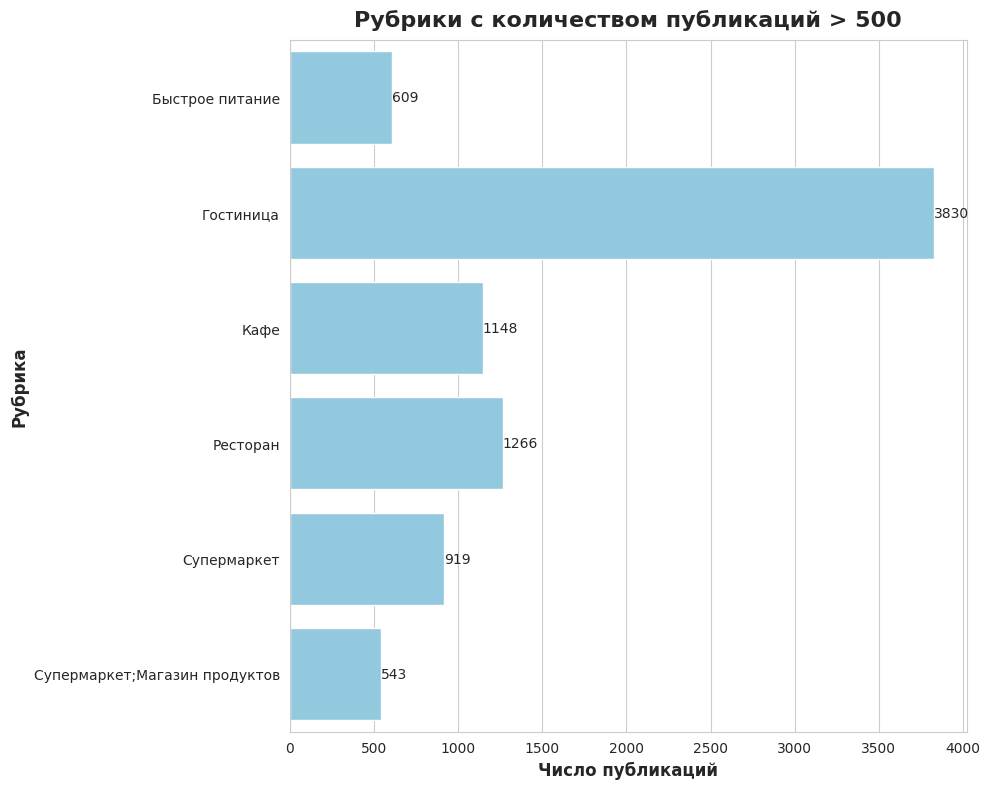

In [ ]:
# Фильтруем данные, чтобы оставить только рубрики с количеством публикаций больше 500
filtered_rubrics = text_by_rubrics[text_by_rubrics['counts'] > 500]
top_rubrics = filtered_rubrics
# Создаем график
plt.figure(figsize=(10,8))
# Строим горизонтальную столбчатую диаграмму
ax = sns.barplot(x='counts', y='rubrics', data=top_rubrics, color='skyblue')
# Добавляем заголовок
plt.title('Рубрики с количеством публикаций > 500', fontsize=16)
# Убираем метки на оси Y (если хотите отображать только рубрики)
plt.xticks(rotation=0)  # Можно оставить без поворота или под углом
plt.xlabel('Число публикаций', fontsize=12)
plt.ylabel('Рубрика', fontsize=12)
# Добавляем подписи для каждого столбца
ax.bar_label(ax.containers[0])
# Показать график
plt.show()

In [ ]:
# Подсчитываем количество записей по названиям заведения
texy_by_name = train_data['name_ru'].value_counts().sort_index().reset_index(name='counts')

# Переименовываем столбцы для удобства
texy_by_name.columns = ['name_ru', 'counts']

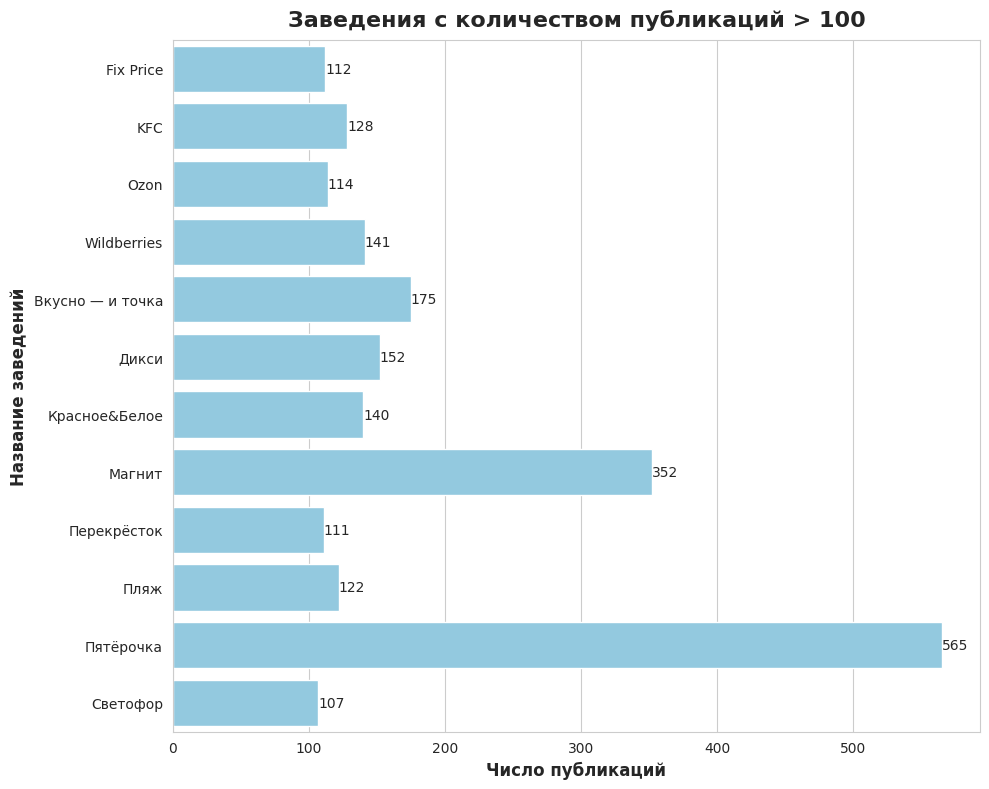

In [ ]:
# Фильтруем данные, чтобы оставить только названиям заведений с количеством публикаций больше 100
filtered_rubrics = texy_by_name[texy_by_name['counts'] > 100]
# Создаем график
plt.figure(figsize=(10,8))
# Строим горизонтальную столбчатую диаграмму
ax = sns.barplot(x='counts', y='name_ru', data=filtered_rubrics, color='skyblue')
# Добавляем заголовок
plt.title('Заведения с количеством публикаций > 100', fontsize=16)
# Убираем метки на оси Y (если хотите отображать только рубрики)
plt.xticks(rotation=0)  # Можно оставить без поворота или под углом
plt.xlabel('Число публикаций', fontsize=12)
plt.ylabel('Название заведений', fontsize=12)
# Добавляем подписи для каждого столбца
ax.bar_label(ax.containers[0])
# Показать график
plt.show()

#### Очистка данных

In [ ]:
df = train_data[['text','rating']] # обучающая выборка

In [ ]:
df_test = test_data[['text','rating']] # тестовая выборка

In [ ]:
df

,text,rating
307651,"Часто беру там обед,хотелось бы чтобы ингредие...",4.0
346839,"Сам отель отличный, чисто, уютно, комфортно. О...",4.0
216171,Всегда сдаю анализы только здесь. Спасибо всем...,5.0
332822,"Возможно еда и интерьер достойны, НО НИ В КОЕМ...",2.0
378645,Комплекс располагается в невероятно живописном...,2.0
...,...,...
86513,Отдельное унижение — самостоятельно заполнять ...,2.0
489910,"Это лучшее заведение где мы были, атмосферно, ...",5.0
59146,"Очень вкусно, но видели тараканов. Персонал ве...",4.0
341424,"Привезли сюда таксу, отказали задние лапы, док...",1.0


Определим функцию очистки твитов.

In [ ]:
# Удаляем пунктуацию, ссылки, упоминание других участников, символы конца строки и переноса \r\n
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').lower() # удаляем \n и \r и переводим строку в нижний регистр
    text = re.sub(r'[^\w\s]', '', text) # удаление всех символов, кроме букв и пробелов
    text = re.sub(r'\d+', '', text) # удаление всех чисел
    return text

# Удаление множественных пробелов
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

Применим функции для очистки твитов:

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(strip_all_entities(t)))

In [ ]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(remove_mult_spaces(strip_all_entities(t)))

Теперь мы можем создать новую колонку `text_clean`, как для обучающих, так и для тестовых наборов, для размещения очищенной версии текста твитов.

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df['text_clean'].head()

,text_clean
307651,часто беру там обедхотелось бы чтобы ингредиен...
346839,сам отель отличный чисто уютно комфортно очень...
216171,всегда сдаю анализы только здесь спасибо всему...
332822,возможно еда и интерьер достойны но ни в коем ...
378645,комплекс располагается в невероятно живописном...


In [ ]:
df['text_clean'][1:8].values

array(['сам отель отличный чисто уютно комфортно очень огорчило что нет кафе на территории отеля нужно было ходить а рядом мало всего и лифта нет мы жили на этаже ходили пешком',
       'всегда сдаю анализы только здесь спасибо всему персоналу за отличное обслуживание и профессионализм',
       'возможно еда и интерьер достойны но ни в коем случае не заказываете их через яндекседу ждал заказ часа на расстояние в километра блюда не могу оценить так как просто не довезли при оформлении заказа было указано время доставки минут в итоге готовили заказ долго потом отдали курьеру а он сначала поехал на другой адрес а потом пропал вообще по итогу яндекс отменили заказ сами в службу поддержки доставки ресторана сложно дозвониться яндексу вообще на все пофигу они ни за что не отвечают и могут вообще не привезти заказ как со мной и произошлов итоге испорченный вечер обеспечен',
       'комплекс располагается в невероятно живописном месте крыма по дороге в новый свет у подножия горы сокол на склон

Также давайте создадим столбец для оценки длины очищенного текста, чтобы контролировать, а не удалили ли мы весь твит?

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

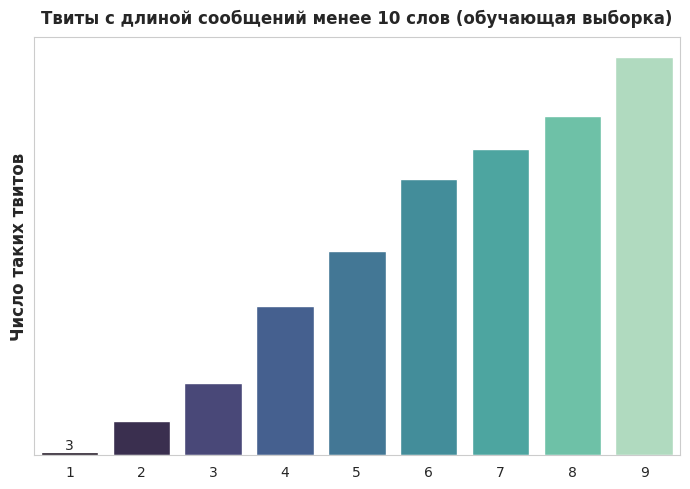

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (обучающая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

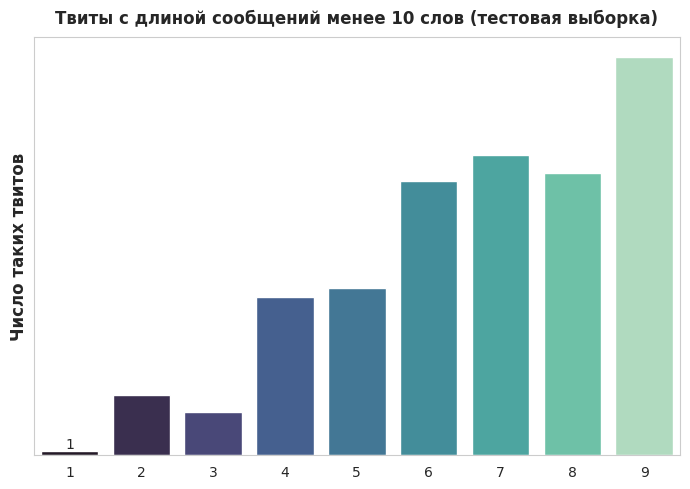

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Твиты с длиной сообщений менее 10 слов (тестовая выборка)')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число таких твитов')
plt.xlabel('')
plt.show()

In [ ]:
print(f"Форма обучающей выборки: {df.shape}")
print(f"Форма тестовой выборки: {df_test.shape}")

Форма обучающей выборки: (40000, 4)
Форма тестовой выборки: (10000, 4)


In [ ]:
df = df[df['text_len'] > 4] # удаляем из обучающей выборки твиты короче 4 слов

In [ ]:
df_test = df_test[df_test['text_len'] > 4] # удаляем из тестовой выборки твиты короче 4 слов

In [ ]:
print(f"Форма обучающей выборки после очистки: {df.shape}")
print(f"Форма тестовой выборки после очистки: {df_test.shape}")

Форма обучающей выборки после очистки: (39786, 4)
Форма тестовой выборки после очистки: (9938, 4)


### Токенизация

Будем использовать предобученный BERT-токенизатор.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('DeepPavlov/bert-base-bg-cs-pl-ru-cased')

Применим токенизатор к "очищенным" данным:

In [ ]:

token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)
mean_len = np.mean(token_lens)

print(f"Максимальная длина токенизированной последовательности: {max_len}")
print(f"Средняя длина токенизированной последовательности: {mean_len}")

Максимальная длина токенизированной последовательности: 512
Средняя длина токенизированной последовательности: 92.77341275825667


Перетасуем его и сбросим индекс.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

Повторим процедуру для тестовой выборки:

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

### Анализ колонки rating

In [ ]:
# Преобразование значений в столбце 'rating' в целые числа
df['rating'] = df['rating'].astype(int)
df_test['rating'] = df_test['rating'].astype(int)

In [ ]:
df['rating'].value_counts()

,count
rating,
2,7985
5,7972
3,7953
1,7939
4,7937


### Балансировка классов

In [ ]:
# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличения выборки к данным (X_resampled, y_resampled = ros.fit_resample(X, y))
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['rating']).reshape(-1, 1));

# Снова объединим выборки в DataFrame
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'rating']);

In [ ]:
train_os['rating'].value_counts()

,count
rating,
1,7985
3,7985
2,7985
4,7985
5,7985


### Обучающая, проверочная и тестовая выборки

In [ ]:
X = train_os['text_clean'].values
y = train_os['rating'].values

Набор для проверки будет извлечен из обучающего набора для контроля точности обучения и предотвращения переобучения.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['rating'].values

In [ ]:
y_test

array([5, 3, 2, ..., 5, 4, 5])

### One hot encoding

Закодируем метки с помощью, хорошо знакомого нам, метода One hot encoding. Зачем мы это делаем? Это стандарт для задач классификации (вспоминаем более ранние уроки)!   

Также сделаем копии наших выборок, они нам еще пригодятся:

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder() # создаем экземпляр класса OneHotEncoder()

# Формируем кодированные OHE метки для тренировочной, проверочной и тестовой выборок
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_valid.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 35932
Проверочная выборка: 3993
Тестовая выборка: 9938


### Базовая модель: Наивный байесовский классификатор

Мы будем в качестве отправной точки использовать "Наивный байесовский классификатор", как простейшую модель классического машинного обучения и обучим ее классифицировать наши твиты:

Токенизируем твиты, используя CountVectorizer:

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Преобразуем токенизированные твиты в формат TF-IDF (частота использования термина, умноженная на частоту использования документа):

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Создаем модель наивного байесовского классификатора:

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

Запустим предсказание на тестовой выборке:

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

Выведем метрики с помощью метода `classification_report` библиотеки `sklearn`:

In [ ]:
print('Расчет метрик для наивного байесовского классификатора:')
print()
print()
print(classification_report(y_test_le, nb_pred, target_names=['1', '2', '3', '4', '5']))


Расчет метрик для наивного байесовского классификатора:


              precision    recall  f1-score   support

           1       0.54      0.69      0.61      2035
           2       0.37      0.42      0.40      1984
           3       0.41      0.29      0.34      2007
           4       0.50      0.53      0.51      1978
           5       0.83      0.66      0.73      1934

    accuracy                           0.52      9938
   macro avg       0.53      0.52      0.52      9938
weighted avg       0.53      0.52      0.52      9938



#Модель DeepPavlov


In [ ]:
# Загрузка модели в PyTorch
from transformers import BertTokenizer, BertModel, TFBertModel
import torch
bert_model_pt = BertModel.from_pretrained('DeepPavlov/bert-base-bg-cs-pl-ru-cased')

Some weights of the model checkpoint at DeepPavlov/bert-base-bg-cs-pl-ru-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Конвертация модели из PyTorch в TensorFlow
bert_model = TFBertModel.from_pretrained('DeepPavlov/bert-base-bg-cs-pl-ru-cased', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

In [ ]:
def create_model_deeppavlov(bert_model, max_len=128):
    # Параметры обучения
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7) # оптимизатор - Adam
    loss = tf.keras.losses.CategoricalCrossentropy()                      # функция потерь - категориальная кросс-энтропия
    accuracy = tf.keras.metrics.CategoricalAccuracy()                     # метрика - категориальная точность

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')         # вход для токенизированной последовательности
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')   # маска

    embeddings = bert_model([input_ids, attention_masks])[1]            # BERT-модель

    output = tf.keras.layers.Dense(5, activation="softmax")(embeddings) # полносвязный слой для классификации OHE (5 нейронов - 5 класса)

    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)

    return model

model = create_model_deeppavlov(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1778534   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [ ]:
history_bert = model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_valid), epochs=4, batch_size=64)

Epoch 1/4
562/562 [==============================] - 943s 2s/step - loss: 1.1389 - categorical_accuracy: 0.5034 - val_loss: 1.0321 - val_categorical_accuracy: 0.5652
Epoch 2/4
562/562 [==============================] - 930s 2s/step - loss: 0.9846 - categorical_accuracy: 0.5752 - val_loss: 1.0436 - val_categorical_accuracy: 0.5590
Epoch 3/4
562/562 [==============================] - 923s 2s/step - loss: 0.9140 - categorical_accuracy: 0.6092 - val_loss: 1.0502 - val_categorical_accuracy: 0.5585
Epoch 4/4
562/562 [==============================] - 923s 2s/step - loss: 0.8416 - categorical_accuracy: 0.6463 - val_loss: 1.0512 - val_categorical_accuracy: 0.5765


311/311 [==============================] - 88s 273ms/step


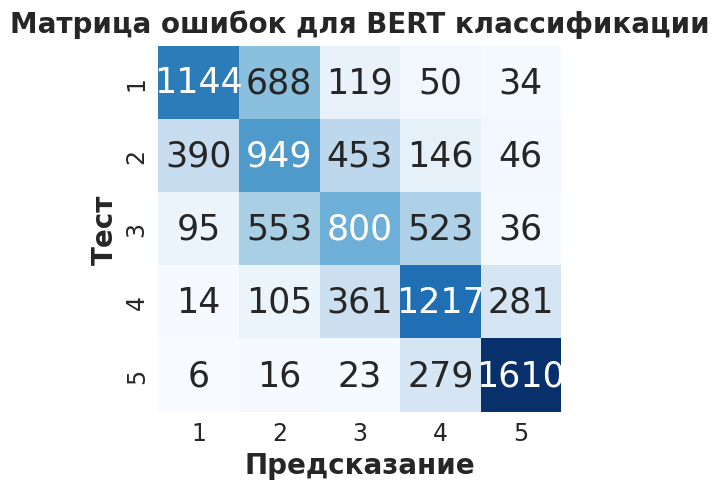

Расчет метрик для BERT классификатора:


              precision    recall  f1-score   support

           1       0.69      0.56      0.62      2035
           2       0.41      0.48      0.44      1984
           3       0.46      0.40      0.43      2007
           4       0.55      0.62      0.58      1978
           5       0.80      0.83      0.82      1934

   micro avg       0.58      0.58      0.58      9938
   macro avg       0.58      0.58      0.58      9938
weighted avg       0.58      0.58      0.58      9938
 samples avg       0.58      0.58      0.58      9938



In [ ]:
result_bert = model.predict([test_input_ids, test_attention_masks])

y_pred_bert = np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1), 'Матрица ошибок для BERT классификации')

print('Расчет метрик для BERT классификатора:')
print()
print()
print(classification_report(y_test, y_pred_bert, target_names=['1', '2', '3', '4', '5']))

In [ ]:
# Предсказания на тестовой выборке
result_bert = model.predict([test_input_ids, test_attention_masks])
y_pred_bert = np.argmax(result_bert, axis=1)

# Выведем примеры предсказаний
for i in range(5):
    print(f"Текст: {df_test['text_clean'].iloc[i]}")
    print(f"Истинный рейтинг: {y_pred_bert[i]}")
    print(f"Предсказанный рейтинг: {y_pred_bert[i]}")
    print("---")

311/311 [==============================] - 86s 277ms/step
Текст: замечательный врач всё хорошо объясняет не пугает ещё хочу отметить работу узиста айдара ильдусовича впечатление осталось хорошее но надеюсь больше не посещать таких мест надеюсь все поняли о чём яnлечащий врач закирова гузалия
Истинный рейтинг: 4
Предсказанный рейтинг: 4
---
Текст: ну так себе персонал работает лучше в другой магазин сходить 
Истинный рейтинг: 2
Предсказанный рейтинг: 2
---
Текст: заказал краску для внутренних работ с доставкой при заказе в комментариях указал цвет коллера для краски краску то привезли но белую принять соответственно отказался леруа сожрало деньги за холостую доставку удержало деньги за саму краску к и ни ответа ни привета создали обращение ждите сколько неизвестно в итоге объект стоит рабочие стоят менеджеры с леруа бездействуют однозначно не рекомендую доставку с этого магазина 
Истинный рейтинг: 1
Предсказанный рейтинг: 0
---
Текст: качество шиномонтажа зависит от настроения мастера ц